In [2]:
!gdown "1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_"

Downloading...
From: https://drive.google.com/uc?id=1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_
To: c:\Users\rizky\OneDrive\Dokumen\GitHub\SudokuSolverDariCitraDigital\kaggle.json

  0%|          | 0.00/63.0 [00:00<?, ?B/s]
100%|██████████| 63.0/63.0 [00:00<?, ?B/s]


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!kaggle datasets download -d macfooty/sudoku-box-detection
!kaggle datasets download -d karnikakapoor/digits
!kaggle datasets download -d karnikakapoor/su-puzzle

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!unzip su-puzzle.zip -d /content/dataset
!unzip sudoku-box-detection.zip -d /content/dataset
!unzip digits.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00081.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00082.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00083.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00084.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00085.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00086.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00087.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00088.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00089.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00090.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00091.jpeg  
  inflating: /content/dataset/digits_jpeg/digits_jpeg/5/img006-00092.jpeg  
  inflating: /content/dataset/digits_

In [10]:
import os
import kaggle
import zipfile
import logging

def download_kaggle_dataset(dataset: str, dir_name: str = "data") -> None:
    initial_dir = os.getcwd()  # Simpan direktori awal
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    os.chdir(dir_name)
    
    # Download dataset
    kaggle.api.dataset_download_files(dataset, path='.', unzip=True)
    
    os.chdir(initial_dir)  # Kembali ke direktori awal

# Atur logging
logging.basicConfig(level=logging.INFO)

# Panggil fungsi dengan nama dataset Kaggle dan parameter yang sesuai
download_kaggle_dataset("macfooty/sudoku-box-detection", dir_name="sudoku-box-detection")
download_kaggle_dataset("karnikakapoor/digits", dir_name="digits")
download_kaggle_dataset("karnikakapoor/su-puzzle", dir_name="su-puzzle")


Dataset URL: https://www.kaggle.com/datasets/macfooty/sudoku-box-detection
Dataset URL: https://www.kaggle.com/datasets/karnikakapoor/digits
Dataset URL: https://www.kaggle.com/datasets/karnikakapoor/su-puzzle


# <p style="background-color:#006989; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:#F3F7EC">Sudoku Solver</p>

<a id='0'></a>
## <p style="background-color:#F3F7EC; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px; color:#F3F7EC;">[Table of Content](#0)</p>

* [1. Importing Libraries 💎](#1)
* [2. Digits Classification](#2)
    * [Integration Data](#3)
    * [Splitting Test Train And Validation Sets](#4)
    * [Preprocessing Data](#5)
    * [Model Building And Training](#6)
* [3. Detecting Sudoku Puzzle](#7)
    * [Read an image from the dataset](#8)
    * [Preprocess the image](#9)
    * [Detecting Countour](#10)
    * [Transformation Perspective](#11)
    * [Split Cels](#12)
* [4 Solving Sudoku](#13)
    * [Detecting Box Sudoku](#14)
    * [Classifying Digits](#15)
    * [Solve Sudoku](#16)


<a id="1"></a>
## Importing Libraries

In [1]:
#Loading Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image
from keras.models import load_model

<a id="2"></a>
## <p style="background-color:#006989; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:#F3F7EC">Digits Classification</p>

<a id="3"></a>
**In this section:**

* Integration Data
* Splitting Test Train And Validation Sets
* Preprocessing Data
* Model Building And Training

<a id="3"></a>
# **<span style="color:#F3F7EC;">Integration Data</span>**

### Dataset Digits

In [13]:
# Specify the path to the dataset
base_path = r"C:\Users\rizky\Downloads\dataset\digits\digits updated\digits updated"

# Check if the base path exists
if not os.path.exists(base_path):
    print(f"Base path does not exist: {base_path}")
else:
    data = os.listdir(base_path)
    data_X = []
    data_y = []
    data_classes = len(data)

    for i in range(data_classes):
        class_path = os.path.join(base_path, str(i))

        # Check if the class path exists
        if not os.path.exists(class_path):
            print(f"Class path does not exist: {class_path}")
            continue

        data_list = os.listdir(class_path)
        for j in data_list:
            img_path = os.path.join(class_path, j)

            # Check if the image path exists
            if not os.path.exists(img_path):
                print(f"Image path does not exist: {img_path}")
                continue

            pic = cv2.imread(img_path)
            if pic is None:
                print(f"Failed to read image: {img_path}")
                continue

            pic = cv2.resize(pic, (32, 32))
            data_X.append(pic)
            data_y.append(i)

    if len(data_X) == len(data_y):
        print("Total Datapoints = ", len(data_X))
    else:
        print("Mismatch in the number of images and labels")

    # Convert to numpy arrays
    data_X = np.array(data_X)
    data_y = np.array(data_y)


Total Datapoints =  10160


### Dataset MNIST

In [14]:
from keras.datasets import mnist

# Load MNIST dataset
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = mnist.load_data()
# Resize MNIST images to 32x32 and convert to RGB
mnist_train_X = np.stack([cv2.resize(img, (32, 32)) for img in mnist_train_X], axis=0)
mnist_test_X = np.stack([cv2.resize(img, (32, 32)) for img in mnist_test_X], axis=0)
mnist_train_X = np.stack([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in mnist_train_X], axis=0)
mnist_test_X = np.stack([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in mnist_test_X], axis=0)


In [15]:
# Combine the local dataset with MNIST dataset
combined_X = np.concatenate((data_X, mnist_train_X, mnist_test_X), axis=0)
combined_y = np.concatenate((data_y, mnist_train_y, mnist_test_y), axis=0)

<a id="4"></a>
# **<span style="color:#F3F7EC;">SPLITTING DATA</span>**

In [16]:
train_X, test_X, train_y, test_y = train_test_split(combined_X, combined_y, test_size=0.05, random_state=42)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (60921, 32, 32, 3)
Validation Set Shape =  (15231, 32, 32, 3)
Test Set Shape =  (4008, 32, 32, 3)


<a id="5"></a>
# **<span style="color:#F3F7EC;">PREPROCESSING DATA</span>**

In [17]:
# Preprocessing the images for neuralnet

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

In [18]:
# One hot encoding of the labels

train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

<a id="6"></a>
# **<span style="color:#F3F7EC;">MODEL BUILDING AND TRAINING</span>**

In [17]:
#Creating a Neural Network

model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 30)          0         
 g2D)                                                   

In [18]:
#Compiling the model

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

#Fit the model
history = model.fit(datagen.flow(train_X, train_y, batch_size=32),
                              epochs = 30, validation_data = (valid_X, valid_y),
                              verbose = 1, steps_per_epoch= 200)

Epoch 1/30
200/200 [==============================] - 56s 279ms/step - loss: 1.2399 - accuracy: 0.5811 - val_loss: 0.3035 - val_accuracy: 0.8951
Epoch 2/30
200/200 [==============================] - 53s 266ms/step - loss: 0.5478 - accuracy: 0.8269 - val_loss: 0.1363 - val_accuracy: 0.9558
Epoch 3/30
200/200 [==============================] - 54s 272ms/step - loss: 0.3823 - accuracy: 0.8822 - val_loss: 0.1209 - val_accuracy: 0.9623
Epoch 4/30
200/200 [==============================] - 50s 251ms/step - loss: 0.3125 - accuracy: 0.9056 - val_loss: 0.0819 - val_accuracy: 0.9752
Epoch 5/30
200/200 [==============================] - 49s 247ms/step - loss: 0.3108 - accuracy: 0.9061 - val_loss: 0.1312 - val_accuracy: 0.9571
Epoch 6/30
200/200 [==============================] - 47s 234ms/step - loss: 0.2556 - accuracy: 0.9275 - val_loss: 0.0714 - val_accuracy: 0.9780
Epoch 7/30
200/200 [==============================] - 48s 241ms/step - loss: 0.2389 - accuracy: 0.9269 - val_loss: 0.0689 - val_ac

KeyboardInterrupt: 

In [10]:
# Testing the model on the test set

score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.05311502143740654
Test Accuracy = 0.9860279560089111


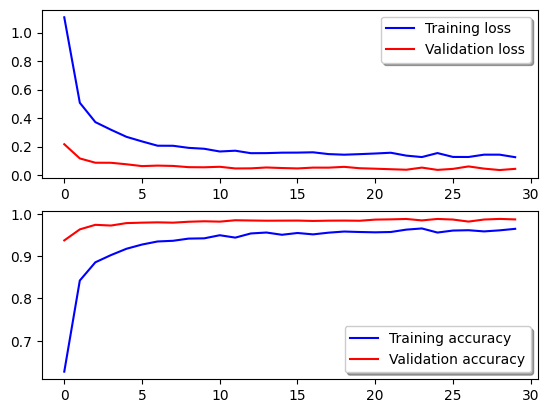

In [11]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

476/476 [==============================] - 12s 25ms/step


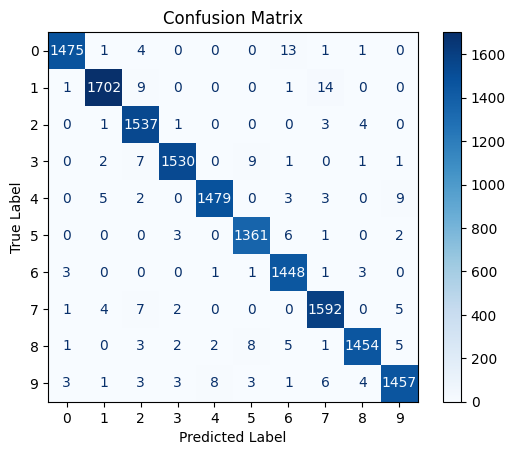

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict the values from the validation dataset
y_pred = model.predict(valid_X)

# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one hot vectors
y_true = np.argmax(valid_y, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx)
disp.plot(cmap='Blues', values_format='d')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
import tensorflow as tf
# Save the model
model.save('my_model.h5')

c:\Users\rizky\anaconda3\envs\myml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
# Load the saved model
model = load_model('models/my_model.h5')

<a id="7"></a>
## <p style="background-color:#006989; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:#F3F7EC">Reading Sudoku Puzzle</p>

**In this section:**

* Read an image from the dataset 
* Preprocess the image 
* Detecting Countour
* Transformation Perspective
* Split Cels

_98_4877013.jpeg


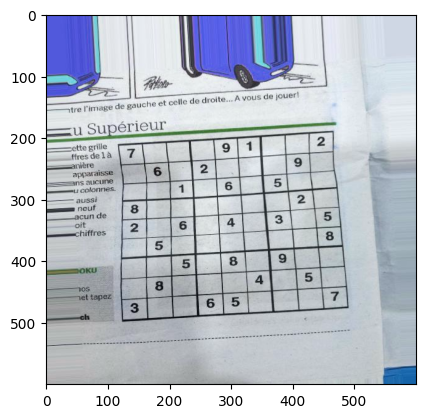

In [19]:
# Randomly select an image from the dataset

folder=r"C:\Users\rizky\Downloads\aug"

a=random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder+'/'+a)
plt.figure()
plt.imshow(sudoku_a)
plt.show()

<a id="8"></a>
# **<span style="color:#F3F7EC;">PREPROCESS IMAGE</span>**

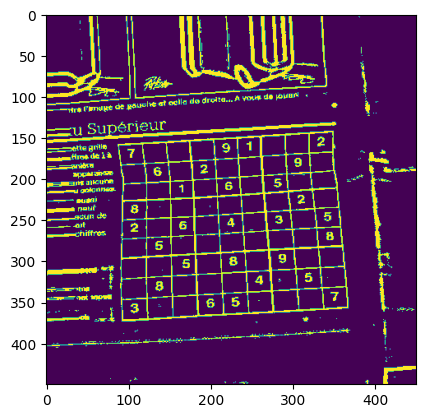

In [20]:
#Preprocessing image to be read
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3),6)
    blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

<a id="9"></a>
# **<span style="color:#F3F7EC;">DETECTING CONTOUR</span>**

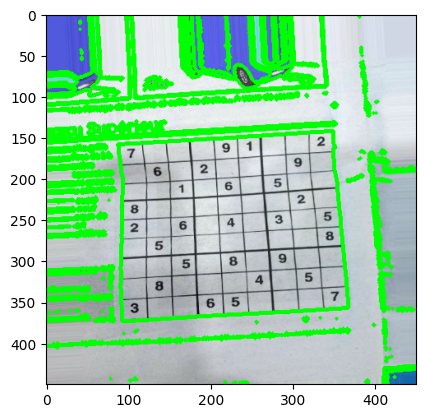

In [21]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

<a id="10"></a>
# **<span style="color:#F3F7EC;">Transformation Perspective</span>**

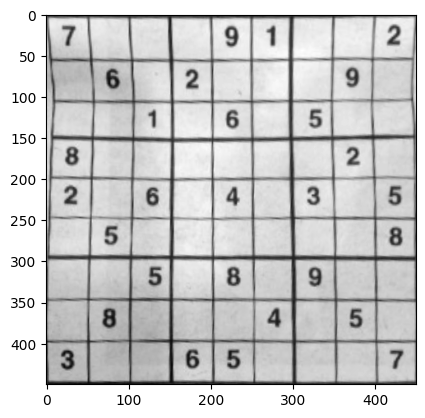

In [22]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(imagewrap,cmap='gray')
plt.show()

<a id="11"></a>
# **<span style="color:#F3F7EC;">SPLIT CELS</span>**

In [23]:
def splitcells(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            # Reduce noise
            denoised_box = cv2.fastNlMeansDenoising(box, None, 30, 7, 21)
            # Convert to black and white
            _, bw_box = cv2.threshold(denoised_box, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            boxes.append(bw_box)
    return boxes

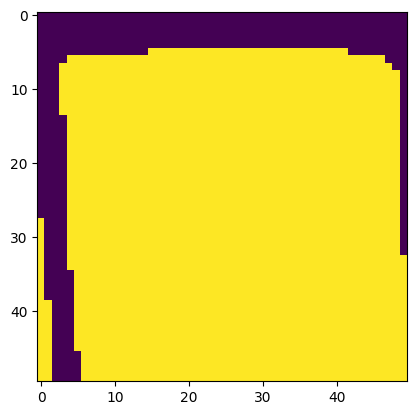

In [24]:
sudoku_cell = splitcells(imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[2])
plt.show()

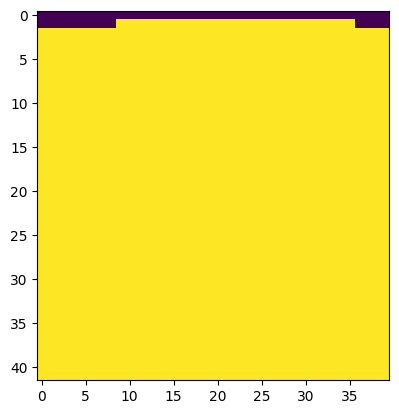

In [25]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:

        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)

    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[2])
plt.show()

<a id="12"></a>
## <p style="background-color:#006989; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:#F3F7EC">Solving Sudoku</p>

**In this section:**

* Real Image Sudoku 
* Detecting Box Sudoku
* Classifying Sudoku Digits
* Solve Sudoku

<a id="3"></a>
# **<span style="color:#F3F7EC;">SUDOKU IMAGE</span>**

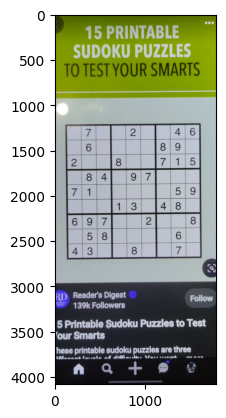

In [26]:
# Importing puzzle to be solved
puzzle = r"captured Image1.jpg"

# puzzle=random.choice(os.listdir(folder_2))
# print(puzzle)
puzzle = cv2.imread(puzzle)
plt.figure()
plt.imshow(puzzle)
plt.show()

<a id="13"></a>
# **<span style="color:#F3F7EC;">DETECTING BOX SUDOKU</span>**

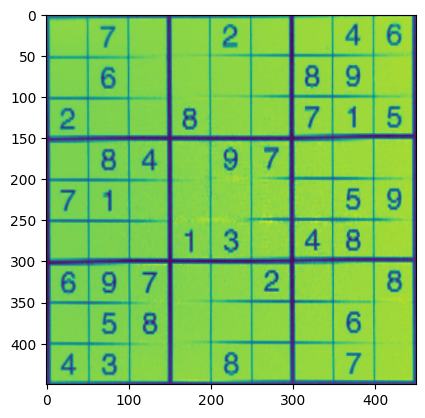

In [27]:
# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle
su_puzzle = preprocess(puzzle)

# Finding the outline of the sudoku puzzle in the image
su_contour_1= su_puzzle.copy()
su_contour_2= su_puzzle.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(su_imagewrap)
plt.show()

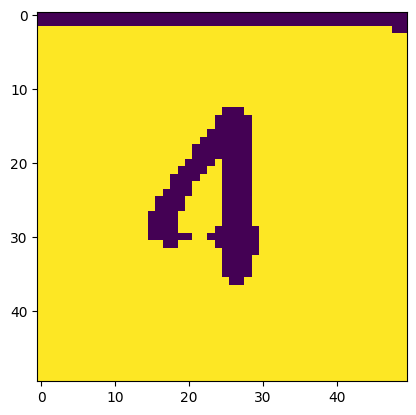

In [28]:
sudoku_cell = splitcells(su_imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[7])
plt.show()

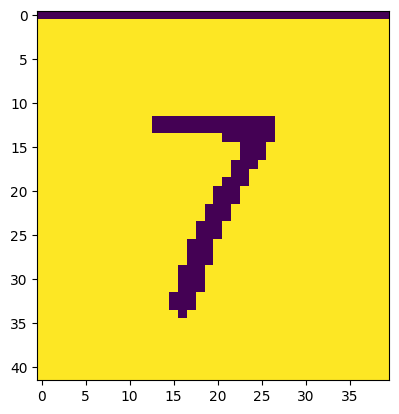

In [29]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:

        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)

    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[1])
plt.show()

<a id="14"></a>
# **<span style="color:#F3F7EC;">CLASSIFYING SUDOKU DIGITS</span>**

In [30]:
def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        # getting predictions and setting the values if probabilities are above 65%

        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=-1)
        probabilityValue = np.amax(predictions)

        if probabilityValue > 0.65:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

1/1 [==============================] - 0s 21ms/step


In [31]:
# Reshaping the grid to a 9x9 matrix
grid = np.reshape(grid,(9,9))
grid

array([[0, 7, 0, 0, 2, 0, 0, 4, 6],
       [0, 6, 0, 0, 0, 0, 8, 9, 0],
       [2, 0, 0, 8, 0, 0, 7, 1, 5],
       [0, 8, 4, 0, 9, 7, 0, 0, 0],
       [7, 1, 0, 0, 0, 0, 0, 5, 9],
       [0, 0, 0, 1, 3, 0, 4, 8, 0],
       [6, 9, 7, 0, 0, 2, 0, 0, 8],
       [0, 5, 8, 0, 0, 0, 0, 6, 0],
       [4, 3, 0, 0, 8, 0, 0, 7, 0]], dtype=int64)

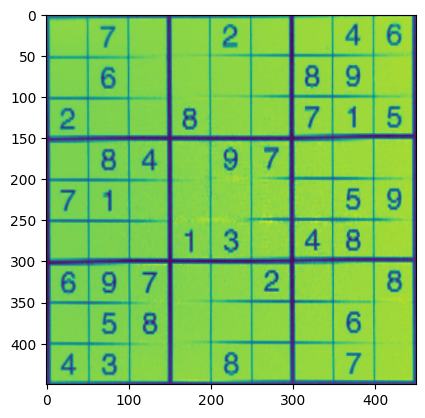

In [32]:
#For compairing
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

<a id="15"></a>
# **<span style="color:#F3F7EC;">SOLVE SUDOKU</span>**

In [33]:
# Function to find the next empty box to solve
def next_box(quiz):
    for row in range(9):
        for col in range(9):
            if quiz[row][col] == 0:
                return (row, col)
    return False

# Function to check if a value n can be placed at quiz[row][col]
def possible(quiz, row, col, n):
    for i in range(9):
        if quiz[row][i] == n:
            return False
    for i in range(9):
        if quiz[i][col] == n:
            return False
        
    row0 = (row // 3) * 3
    col0 = (col // 3) * 3
    for i in range(row0, row0 + 3):
        for j in range(col0, col0 + 3):
            if quiz[i][j] == n:
                return False
    return True

# Recursion function to loop until a valid solution is found
def solve(quiz):
    val = next_box(quiz)
    if val is False:
        return True
    else:
        row, col = val
        for n in range(1, 10):
            if possible(quiz, row, col, n):
                quiz[row][col] = n
                if solve(quiz):
                    return True
                quiz[row][col] = 0
        return False

# Function to print the solved quiz
def Solved(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")


In [34]:
solve(grid)

True

In [35]:
import time
# Measure the computation time using time.perf_counter()
start_time = time.perf_counter()
if solve(grid):
    end_time = time.perf_counter()
    print("Sudoku solved successfully!")
    Solved(grid)
else:
    end_time = time.perf_counter()
    print("No solution exists for the given Sudoku puzzle.")

computation_time_ms = (end_time - start_time) * 1000
print(f"Computation time: {computation_time_ms:.6f} milliseconds")

Sudoku solved successfully!
8 7 5 | 9 2 1 | 3 4 6
3 6 1 | 7 5 4 | 8 9 2
2 4 9 | 8 6 3 | 7 1 5
....................
5 8 4 | 6 9 7 | 1 2 3
7 1 3 | 2 4 8 | 6 5 9
9 2 6 | 1 3 5 | 4 8 7
....................
6 9 7 | 4 1 2 | 5 3 8
1 5 8 | 3 7 9 | 2 6 4
4 3 2 | 5 8 6 | 9 7 1
Computation time: 0.132200 milliseconds


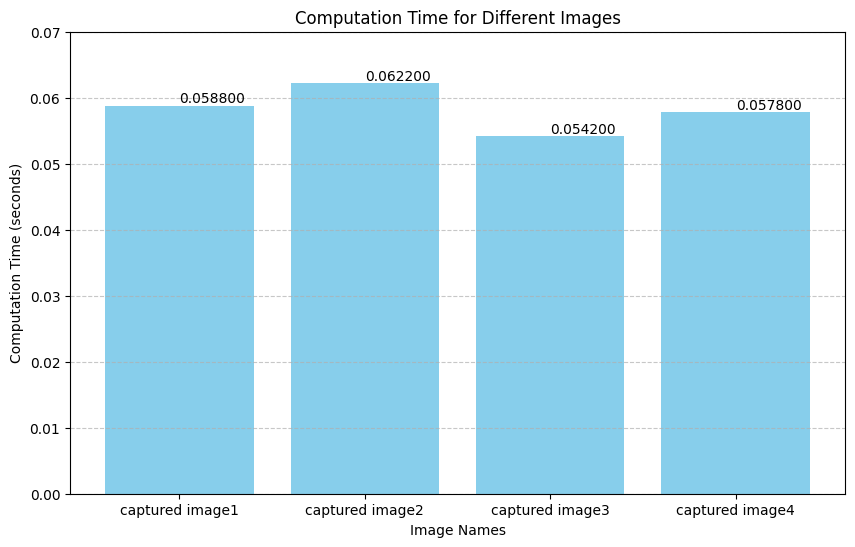

In [71]:
import matplotlib.pyplot as plt

# Data preparation
images = ['captured image1', 'captured image2', 'captured image3', 'captured image4']
times = [0.058800, 0.062200, 0.054200, 0.057800]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(images, times, color='skyblue')

# Add labels and title
plt.xlabel('Image Names')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time for Different Images')
plt.ylim(0, 0.07)  # Set y-axis limit for better readability

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.6f}', va='bottom')  # va: vertical alignment

# Display the chart
plt.show()